# Benoit's Problem with various RTO Algorithms

In [67]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
import matplotlib.pyplot as plt

# 0. Benoit's Problem

In [68]:

# Actual Plant System
def Benoit_System_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2 + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2. + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def con1_system_tight(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] + np.random.normal(0., np.sqrt(1e-3))
    return -g1


def Benoit_System_noiseless_1(u):
    f = u[0] ** 2 + u[1] ** 2 + u[0] * u[1]   # + np.random.normal(0., np.sqrt(1e-3))
    return f

def Benoit_System_noiseless_2(u):
    f = u[0] ** 2 + u[1] ** 2 + (1 - u[0] * u[1])**2  # + np.random.normal(0., np.sqrt(1e-3))
    return f


def con1_system_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1] - 2.  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

def con1_system_tight_noiseless(u):
    g1 = 1. - u[0] + u[1] ** 2 + 2. * u[1]  # + np.random.normal(0., np.sqrt(1e-3))
    return -g1

## Diagram for Benoit's Problem

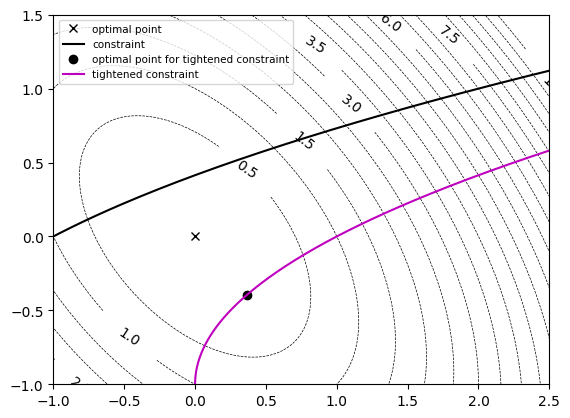

In [69]:
# Plot for objective function 
def plant_drawing(is_constraint,is_tight_constraint):
        delta = 0.01
        x = np.arange(-3.5, 3.5, delta)
        y = np.arange(-3.5, 3.5, delta)
        u = np.meshgrid(x, y)
        levels = np.linspace(0,10,21)

        CS1 = plt.contour(u[0],u[1],Benoit_System_noiseless_1(u),levels,colors='k',linestyles = "dashed",linewidths = 0.5)
        plt.clabel(CS1,inline=True)
        plt.axis((-1, 2.5, -1, 1.5))

        if is_constraint == True:
                # Plot for optimal value for optimization with constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_noiseless(u)}) 
                result = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})
                
                ustar = result.x
                fstar = result.fun
                plt.plot(ustar[0],ustar[1],'kx')
                
                # Plot for constraint
                uc0 = 1. + x ** 2 + 2. * x - 2.
                constraint1 = plt.plot(uc0,x,'k')

        if is_tight_constraint == True:

                # Plot for optimal value for optimization with tightened constraint
                u0 = [2,1] 
                con = ({'type': 'ineq', 
                        'fun': lambda u: con1_system_tight_noiseless(u)}) 
                result_tight = minimize(Benoit_System_noiseless_1,
                                u0,
                                constraints= con,
                                method='SLSQP',
                                options={'ftol': 1e-9})

                ustar = result_tight.x
                fstar = result_tight.fun
                plt.plot(ustar[0],ustar[1],'ko')

                # Plot for tightened constraint

                uc0t = 1. + x ** 2 + 2. * x
                constraint2 = plt.plot(uc0t,x,'m')

# plant_drawing(is_constraint=True,is_tight_constraint=False)
plant_drawing(is_constraint=True,is_tight_constraint=True)
plt.legend(["optimal point",
            "constraint",
            'optimal point for tightened constraint',
            'tightened constraint'],
                fontsize = 7.5)
plt.show()

# 1. Model Adaptation (Two step approach)

## A. Benoit Model (Modified Version) 

In [70]:
# Plant Model 
def Benoit_Model(u,theta):
    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2
    return f

def con1_model(u,theta):
    g1 = 1. - theta[2]*u[0] + theta[3]*u[1] ** 2 
    return -g1

## B. Optimization on cost function

Optimization algorithm on cost function to find optimized input u given parameter

In [71]:
# Optimization on cost function
def cost_optimize(theta,u0):
    con = ({'type': 'ineq', 
            'fun': lambda u: con1_model(u,theta)}) 
    result = minimize(Benoit_Model,
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options={'ftol': 1e-9},
                    args= (theta))

    return result.x,result.fun

In [72]:
# # Test
# u0 = [1,1] # Initial guess for optimization algorithm
# theta = [0.5,0.5,0.5,0.5]
# u,fun = cost_optimize(theta,u0)
# print(f"optimal input: {u}, optimal output: {fun}")


## C. Model Adaptation

We try to minimize difference between output of an actual plant and output of a model. 

The difference is measured by SSE (Sum of Squared Error), which is used for cost function to be minimized

In [73]:
# cost function of adaptation
def SSE(theta,u,plant_func,plant_constraint):

    func_diff = plant_func(u) - Benoit_Model(u,theta)
    con_diff = -(plant_constraint(u) - con1_model(u,theta))

    return np.sqrt(func_diff**2+con_diff**2)

# Model Adaptation (Optimization of Parameters)
def SSE_optimize(plant_func,plant_constraint,theta0,u):

    result = minimize(SSE,
                      theta0,
                      method='SLSQP',
                      args= (u,plant_func,plant_constraint),
                      options= {'ftol': 1e-9})
    
    return result.x,result.fun


In [74]:
# # test for adaptation cost function
# x = SSE(theta = [0.5,0.5,0.5,0.5],
#         u = [2,0],
#         plant_func = Benoit_System_noiseless_1,
#         plant_constraint =con1_system_noiseless)

# print(f"cost function:{x}")
# print("------------")

# # test for model adaptation method
# theta,fun = SSE_optimize(plant_func=Benoit_System_noiseless_1,
#                      plant_constraint=con1_system_noiseless,
#                      theta0=[0.5,0.5,0.5,0.5],
#                      u=[2.00000000e+00,-1.89234472e-08])

# print(f"optimal hyperparameters:{theta},\noptimal function: {fun}")

## D. Overall Algorithm

### I. Plant system 1: 
- "Benoit_System_noiseless_1"
- "con1_system_noiseless" constraint

In [75]:
# Initial Guess (k=0)
uk = [2,-1]
thetak = [0.5,0.5,0.5,0.5]

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['parameters'] = []
for i in range(len(thetak)):
    data['parameters'].append([thetak[i]])
data['cost'] = [Benoit_Model(u=uk,theta=thetak)]

for i in range(5):


    # Model Optimization
    uk_1,fun = cost_optimize(theta=thetak,u0=uk)

    # Model Adaptation
    thetak_1,cost = SSE_optimize(plant_func=Benoit_System_noiseless_1,
                        plant_constraint=con1_system_noiseless,
                        theta0=thetak,
                        u=uk_1)

    uk = uk_1
    thetak = thetak_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(thetak)):
        data['parameters'][i].append(thetak[i])
    data['cost'].append(fun) 

### II. Result 

#### i. Trace of optimal input made by Model Adaptation Algorithm

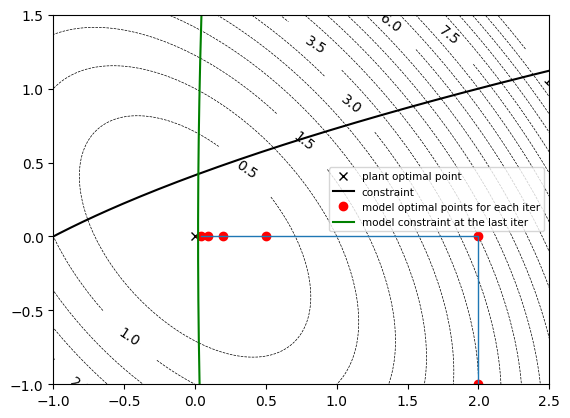

In [76]:
plant_drawing(is_constraint=True,is_tight_constraint=False)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-3.5, 3.5, delta)
uc0 = (data['parameters'][3][-1]*uc1**2 + 1)/data['parameters'][2][-1]
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

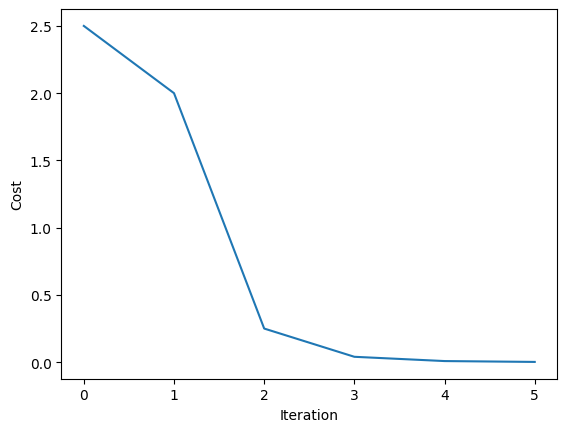

In [77]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Parameters of model through 5 iterations

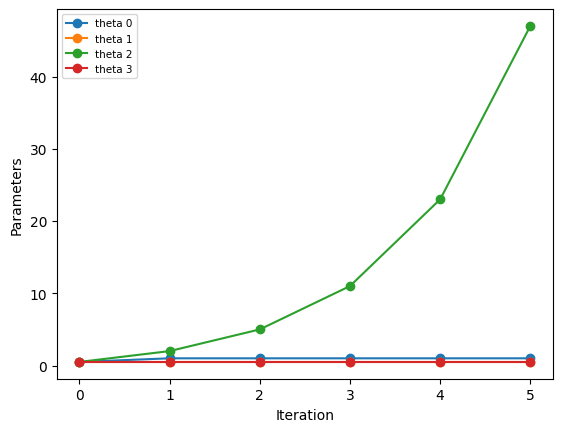

In [78]:
plt.plot(data['index'],
         data['parameters'][0],
         data['index'],
         data['parameters'][1],
         data['index'],
         data['parameters'][2],
         data['index'],
         data['parameters'][3],
         marker='o')
plt.legend(["theta 0",
            "theta 1",
            "theta 2",
            "theta 3"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Parameters")
plt.show()

### III. Plant system 2: 
- "Benoit_System_noiseless_1" 
- "con1_system_tight_noiseless" constraint

In [79]:
# Initial Guess (k=0)
uk = [2,-1]
thetak = [0.5,0.5,0.5,0.5]

# dictionary: uk_1, fun, thetak_1, cost, 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['parameters'] = []
for i in range(len(thetak)):
    data['parameters'].append([thetak[i]])
data['cost'] = [Benoit_Model(u=uk,theta=thetak)]

for i in range(5):

    # Model Optimization
    uk_1,fun = cost_optimize(theta=thetak,u0=uk)
    
    # Model Adaptation
    thetak_1,cost = SSE_optimize(plant_func=Benoit_System_noiseless_1,
                        plant_constraint=con1_system_tight_noiseless,
                        theta0=thetak,
                        u=uk_1)

    uk = uk_1
    thetak = thetak_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(thetak)):
        data['parameters'][i].append(thetak[i])
    data['cost'].append(fun)


### IV. Result 

#### i. Trace of optimal input made by Model Adaptation Algorithm

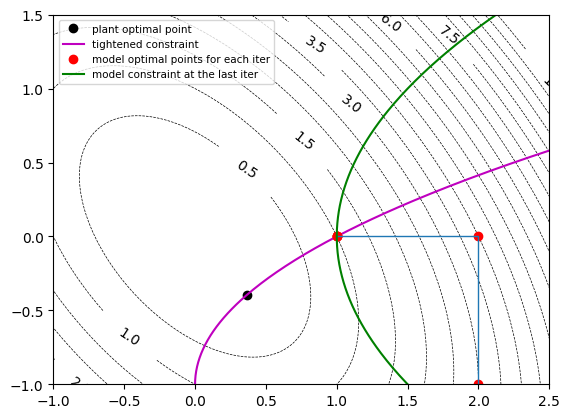

In [80]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro')
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-3.5, 3.5, delta)
uc0 = (data['parameters'][3][-1]*uc1**2 + 1)/data['parameters'][2][-1]
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "tightened constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

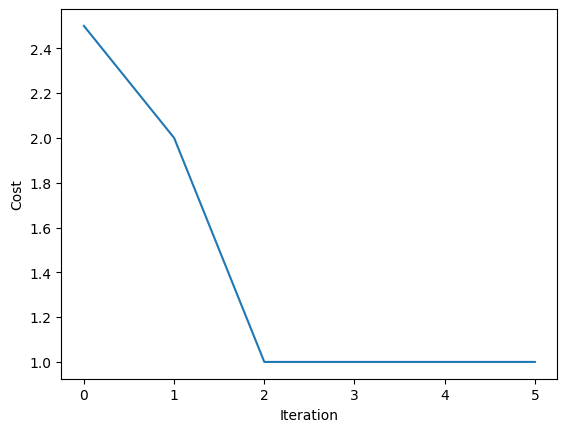

In [81]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Parameters of model through 5 iterations

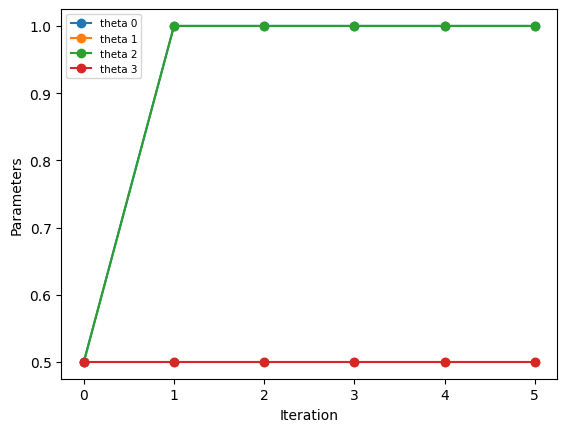

In [82]:
plt.plot(data['index'],data['parameters'][0],data['index'],data['parameters'][1],data['index'],data['parameters'][2],data['index'],data['parameters'][3],
         marker='o')
plt.legend(["theta 0",
            "theta 1",
            "theta 2",
            "theta 3"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Parameters")
plt.show()

# 2. Model Adaptation with increased Model Flexibility

The code has huge similarities with the above code. However, few modifications are made to have higher model flexibility and match KKT conditions. The modifications are done as follows:

- Added bias parameters on both cost function and constraint to match KKT conditions. 
- Also, model adaptation step has included minimizing difference between plant and model of gradients in cost function and constraint. 

In [83]:
# Plant Model 
def Benoit_Model(u,theta):
    f = theta[0] * u[0] ** 2 + theta[1] * u[1] ** 2 + theta[2]
    return f

def con1_model(u,theta):
    g1 = 1. - theta[3]*u[0] + theta[4]*u[1] ** 2 + theta[5]
    return -g1

## B. Optimization on cost function

Optimization algorithm on cost function to find optimized input u given parameter

In [84]:
# Optimization on cost function
def cost_optimize(theta,u0):
    con = ({'type': 'ineq', 
            'fun': lambda u: con1_model(u,theta)}) 
    result = minimize(Benoit_Model,
                    u0,
                    constraints= con,
                    method='SLSQP',
                    options={'ftol': 1e-9},
                    args= (theta))

    return result.x,result.fun

In [85]:
# Test
u0 = [1,1] # Initial guess for optimization algorithm
theta = [0.5,0.5,0.5,0.5,0.5,0.5]
u,fun = cost_optimize(theta,u0)
print(f"optimal input: {u}, optimal output: {fun}")

optimal input: [ 3.00000000e+00 -6.98000908e-10], optimal output: 4.999999999960751


## C. Model Adaptation

We try to minimize difference between output of an actual plant and output of a model. 

The difference is measured by SSE (Sum of Squared Error), which is used for cost function to be minimized

In [86]:
# gradient modifier
def gradient_estimation(u,fun):
    # step
    du = np.sqrt(1e-3) # np.finfo
    u = np.array(u)
    # Predicted gradient from real plant
    gradient_u0 = (fun(u+[du,0]) - fun(u))/du
    gradient_u1 = (fun(u+[0,du]) - fun(u))/du
    gradient = [gradient_u0,gradient_u1]
    
    return gradient

# cost function of adaptation
def SSE(theta,u,plant_func,plant_constraint):

    func_error = (plant_func(u) - Benoit_Model(u,theta))**2/np.abs(plant_func(u))
    con_error = (plant_constraint(u) - con1_model(u,theta))**2/np.abs(plant_constraint(u))

    # Calculate relavent gradients:
    gradient_cost_p = gradient_estimation(u,plant_func)
    ## Gradient of plant constraint function
    gradient_con1_p = gradient_estimation(u,plant_constraint)
    ## Gradient of model cost function
    gradient_cost_m = approx_fprime(u,Benoit_Model,np.sqrt(1e-3),theta)
    ## Gradient of model constraint function
    gradient_con1_m = approx_fprime(u,con1_model,np.sqrt(1e-3),theta)
    ## Gradient of plant cost function

    gradient_func_error = np.sum((gradient_cost_p - gradient_cost_m)**2/np.abs(gradient_cost_p))
    gradient_con1_error = np.sum((gradient_con1_p - gradient_con1_m)**2/np.abs(gradient_con1_p))

    # print(f"input: {u}, theta: {theta}, \n 
    #       cost diff: {func_diff}, constraint diff: {con_diff}, 
    #       gradient cost diff: {gradient_func_diff}, gradient constraint diff: {gradient_con1_diff}")

    return np.sqrt((func_error+con_error+gradient_func_error+gradient_con1_error))


# Model Adaptation (Optimization of Parameters)
def SSE_optimize(plant_func,plant_constraint,theta0,u):

    result = minimize(SSE,
                      theta0,
                      method='SLSQP',
                      args= (u,plant_func,plant_constraint),
                      options= {'ftol': 1e-9})
    
    return result.x,result.fun

In [87]:
# # test for adaptation cost function
# x = SSE(theta = [0.5,0.5,0.5,0.5,0.5,0.5],
#         u = [3,0],
#         plant_func = Benoit_System_noiseless_1,
#         plant_constraint =con1_system_noiseless)

# print(f"cost function:{x}")
# print("------------")

# # test for model adaptation method
# theta,fun = SSE_optimize(plant_func=Benoit_System_noiseless_1,
#                      plant_constraint=con1_system_noiseless,
#                      theta0=[0.5,0.5,0.5,0.5,0.5,0.5],
#                      u=[2.00000000e+00,-1.89234472e-08])

# print(f"optimal hyperparameters:{theta},\noptimal function: {fun}")

## D. Overall Algorithm

### I.Plant System 1: 
- "Benoit_System_noiseless_1"
- "con1_system_noiseless" constraint

In [88]:
# Initial Guess (k=0)
uk = [2,-1]
thetak = [0.5,0.5,0.5,0.5,0.5,0.5]
plant_fun = Benoit_System_noiseless_1
plant_con1 = con1_system_noiseless

# Dictionary for data collection 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['parameters'] = [[thetak[i]] for i in range(len(thetak))]
data['cost'] = [Benoit_Model(u=uk,theta=thetak)]

for i in range(10):
    # Model Optimization
    uk_1,fun = cost_optimize(theta=thetak,u0=uk)

    # Model Adaptation
    thetak_1,cost = SSE_optimize(plant_func=Benoit_System_noiseless_1,
                        plant_constraint=con1_system_noiseless,
                        theta0=thetak,
                        u=uk_1)
    
    uk = uk_1
    thetak = 0.8*np.array(thetak) + 0.2*thetak_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(thetak)):
        data['parameters'][i].append(thetak[i])
    data['cost'].append(fun) 
    

### II. Result 

#### i. Trace of optimal input made by Model Adaptation Algorithm

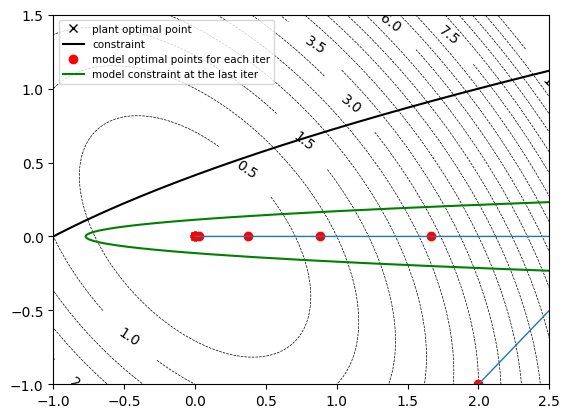

In [89]:
plant_drawing(is_constraint=True,is_tight_constraint=False)
plt.plot(data['u_0'],data['u_1'], 'ro',)
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-3.5, 3.5, delta)
uc0 = (data['parameters'][4][-1]*uc1**2+ data['parameters'][5][-1] + 1)/data['parameters'][3][-1]
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()

#### ii. Cost Function through 5 iterations

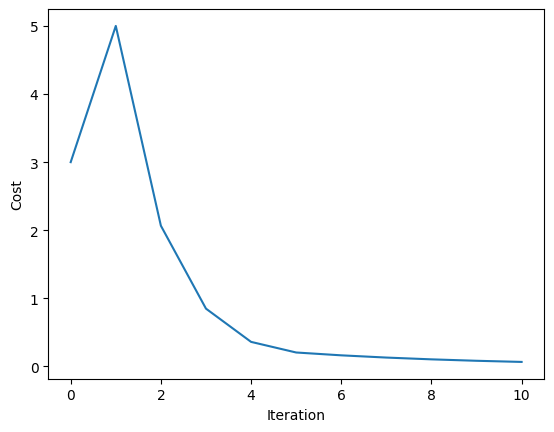

In [90]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

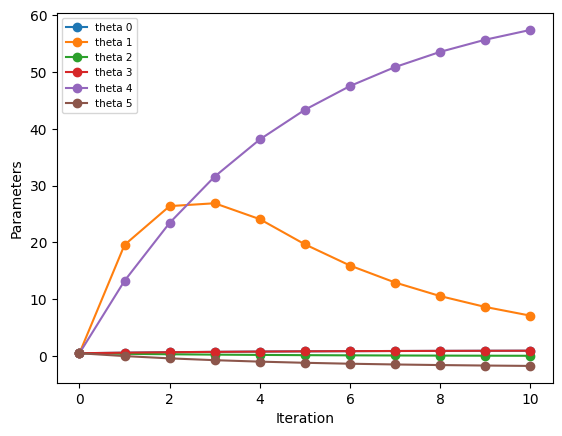

In [91]:
plt.plot(data['index'],
         data['parameters'][0],
         data['index'],
         data['parameters'][1],
         data['index'],
         data['parameters'][2],
         data['index'],
         data['parameters'][3],
         data['index'],
         data['parameters'][4],
         data['index'],
         data['parameters'][5],
         marker='o')
plt.legend(["theta 0",
            "theta 1",
            "theta 2",
            "theta 3",
            "theta 4",
            "theta 5"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Parameters")
plt.show()

### III. Plant system 2: 
- "Benoit_System_noiseless_1" 
- "con1_system_tight_noiseless" constraint

In [92]:
# Initial Guess (k=0)
uk = [1,-0.75]
thetak = [1.5,1.5,1.5,1.5,1.5,1.5]

# dictionary: uk_1, fun, thetak_1, cost, 
data = {}
data['index'] = [0]
data['u_0'] = [uk[0]]
data['u_1'] = [uk[1]]
data['parameters'] = [[thetak[i]] for i in range(len(thetak))]
data['cost'] = [Benoit_Model(u=uk,theta=thetak)]

for i in range(20):

    # Model Optimization
    uk_1,fun = cost_optimize(theta=thetak,u0=uk)
    
    # Model Adaptation
    thetak_1,cost = SSE_optimize(plant_func=Benoit_System_noiseless_1,
                        plant_constraint=con1_system_tight_noiseless,
                        theta0=thetak,
                        u=uk_1)

    uk = uk_1
    thetak = 0.8*np.array(thetak) + 0.2*thetak_1
    # thetak = thetak_1

    # Collecting data
    data['index'].append(i+1)
    data['u_0'].append(uk[0]), data['u_1'].append(uk[1])
    for i in range(len(thetak)):
        data['parameters'][i].append(thetak[i]) 
    data['cost'].append(fun) 

### IV. Result 

#### i. Trace of optimal input made by Model Adaptation Algorithm

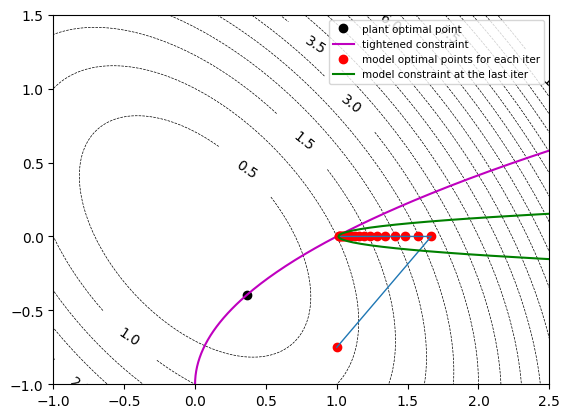

1.0057645661070607 33.908237091696115 0.017293959813795147 1.0057644374265553 63.5220101720232 0.017293710749042766


In [93]:
plant_drawing(is_constraint=False,is_tight_constraint=True)
plt.plot(data['u_0'],data['u_1'], 'ro')
plt.plot(data['u_0'],data['u_1'], linestyle='-',linewidth=1,label='_nolegend_')
delta = 0.01
uc1 = np.arange(-3.5, 3.5, delta)
uc0 = (data['parameters'][4][-1]*uc1**2+ data['parameters'][5][-1] + 1)/data['parameters'][3][-1]
plt.plot(uc0,uc1,'g')
plt.legend(["plant optimal point",
            "tightened constraint",
            'model optimal points for each iter',
            'model constraint at the last iter'],
                fontsize = 7.5)
plt.show()
print(data['parameters'][0][-1],data['parameters'][1][-1],data['parameters'][2][-1],data['parameters'][3][-1],data['parameters'][4][-1],data['parameters'][5][-1])

#### ii. Cost Function through 5 iterations

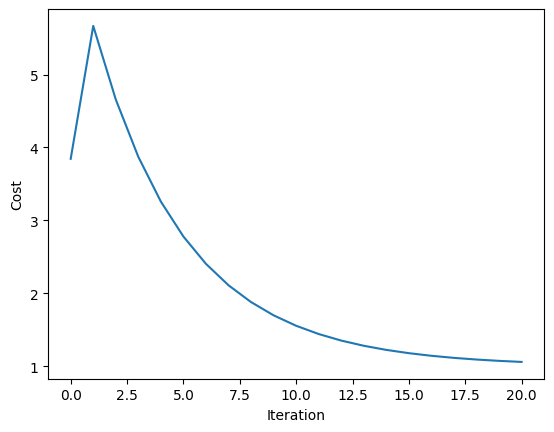

In [94]:
plt.plot(data['index'],data['cost'])
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

#### iii. Parameters of model through 5 iterations

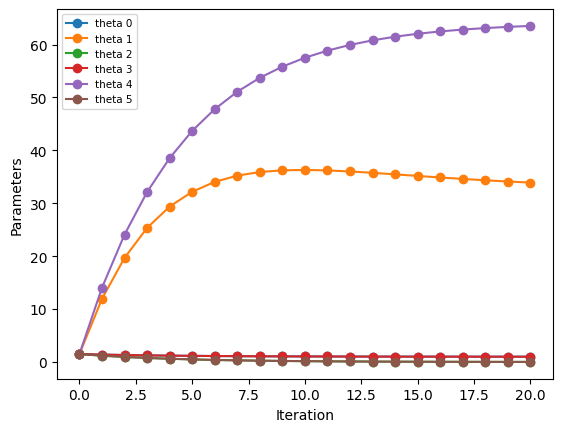

In [95]:
plt.plot(data['index'],
         data['parameters'][0],
         data['index'],
         data['parameters'][1],
         data['index'],
         data['parameters'][2],
         data['index'],
         data['parameters'][3],
         data['index'],
         data['parameters'][4],
         data['index'],
         data['parameters'][5],
         marker='o')
plt.legend(["theta 0",
            "theta 1",
            "theta 2",
            "theta 3",
            "theta 4",
            "theta 5"],
            fontsize = 7.5)
plt.xlabel("Iteration"), plt.ylabel("Parameters")
plt.show()

In [96]:
theta = [0.9942353854135089, 34.40479447223855, 0.0057646023742881245, 0.994235377330289, 63.510647354857994, 0.005764571638136008]
u = [1.01451610e+00, -3.67632843e-09]
plant_func = Benoit_System_noiseless_1
plant_constraint = con1_system_tight_noiseless
error = SSE(theta,u,plant_func,plant_constraint)
print(error)
uk_1,fun = cost_optimize(theta,u0=u)
print(uk_1)


0.10644691786159423
[ 1.01159604e+00 -3.51829407e-09]
